In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from medmnist import INFO  # Contains dataset metadata
import medmnist          # This imports all available MedMNIST dataset classes
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [2]:
!git clone https://github.com/AntonioTepsich/Convolutional-KANs.git

Cloning into 'Convolutional-KANs'...
remote: Enumerating objects: 2379, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2379 (delta 266), reused 311 (delta 196), pack-reused 1970 (from 1)
Receiving objects: 100% (2379/2379), 45.65 MiB | 797.00 KiB/s, done.
Resolving deltas: 100% (1286/1286), done.


In [3]:
%cd Convolutional-KANs

/Users/home/Documents/pytorch-test/Convolutional-KANs


/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:

%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 1.1 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pa

In [51]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.SimpleModels import *
from architectures_28x28.ConvNet import ConvNet
from architectures_28x28.KANConvs_MLP import KANC_MLP
from architectures_28x28.KKAN import KKAN_Convolutional_Network
from architectures_28x28.conv_and_kan import NormalConvsKAN
from kan_convolutional.KANConv import KAN_Convolutional_Layer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image  # Import PIL's Image module

class MyMedNISTDataset(Dataset):
    def __init__(self, npz_path, split='train', transform=None):
        super().__init__()
        self.split = split
        self.transform = transform
        
        # Load data from .npz using NumPy
        data_dict = np.load(npz_path)
        
        # Based on the chosen split, pick the corresponding arrays
        if split == 'train':
            self.images = data_dict['train_images']
            self.labels = data_dict['train_labels']
        elif split == 'val':
            self.images = data_dict['val_images']
            self.labels = data_dict['val_labels']
        elif split == 'test':
            self.images = data_dict['test_images']
            self.labels = data_dict['test_labels']
        else:
            raise ValueError(f"Unknown split: {split} (expected 'train', 'val', or 'test')")
        
        # Convert labels to a 1D array if necessary
        self.labels = np.squeeze(self.labels)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert image to float32 if needed
        image = image.astype(np.float32)
        
        # Convert NumPy array to PIL Image.
        # Note: Depending on your data's value range, you might need to adjust this.
        # For example, if your data is already in [0, 255] you can convert directly.
        # If it's in [0, 1], consider scaling by 255 first.
        image = Image.fromarray(np.uint8(image))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [45]:
def get_transforms(n_channels):
    # If not 3 channels, first convert to 3 channels; otherwise, use identity.
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform

    return train_transform, val_transform, test_transform

# EXAMPLE USAGE
# for key in dataset_keys:
#     info = INFO[key]
#     n_channels = info.get('n_channels', 1)
#     npz_path = f"./data/{key}.npz"
#     train_dataset = MyMedNISTDataset(
#         npz_path=npz_path,
#         split='train',
#         transform=get_transforms(n_channels)[0]
#     )
#     print(f"Train {key} size:", len(train_dataset))

# Create a DataLoader to batch and shuffle
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

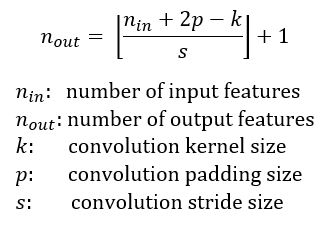

# Trying diff architectures

In [270]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class conv_block(nn.Module):
#     def __init__(self, in_channels, out_channels, **kwargs):
#         super(conv_block, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, **kwargs)
#         self.batchnorm = nn.BatchNorm2d(out_channels)
    
#     def forward(self, x):
#         # Use functional ReLU (non-inplace by default)
#         x = F.relu(self.batchnorm(self.conv1(x)))
#         return x

import torch
import torch.nn as nn
import torch.nn.functional as F

# A helper block that performs Conv -> BatchNorm -> ReLU.
def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size,
                  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# A helper block that omits the ReLU activation (used for the final conv and shortcut).
def conv_block_no_act(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size,
                  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

class ResBlock50(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion=4):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Desired number of output channels.
                                Must be divisible by 'expansion'.
            stride (int): Stride for the 3x3 convolution (for spatial downsampling).
            expansion (int): Expansion factor to compute the bottleneck channels.
                             For ResNet-50, this is typically 4.
        """
        super(ResBlock50, self).__init__()
        
        # Compute the bottleneck (intermediate) channel count.
        bottleneck_channels = out_channels // expansion
        
        # First 1x1 convolution: reduce dimensions.
        self.conv1 = conv_block(in_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0)
        # 3x3 convolution: spatial processing (with possible downsampling).
        self.conv2 = conv_block(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1)
        # Final 1x1 convolution: expand dimensions. No ReLU here.
        self.conv3 = conv_block_no_act(bottleneck_channels, out_channels, kernel_size=1, stride=1, padding=0)
        
        # Shortcut path: if dimensions differ (either spatially or in channel depth),
        # use a 1x1 convolution to match the dimensions.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = conv_block_no_act(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        # Out-of-place addition for the residual connection.
        out = torch.add(out, identity)
        out = F.relu(out)
        return out



class inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, out_1x1_pool):
        super(inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1_pool, kernel_size=1)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        outputs = [branch1, branch2, branch3]
        return torch.cat(outputs, 1)

class ResBlock18(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution: always stride=1, keeps spatial dimensions same
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection: if input and output dimensions differ, adjust using 1x1 convolution
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x  # Save input for the residual connection
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Adjust dimensions if necessary
        identity = self.shortcut(id)
        
        x += identity  # Residual addition
        x = F.relu(x)
        return x



# Model 1

In [291]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------------------
# Define a Basic Residual Block
# -----------------------------------------
class BasicBlock(nn.Module):
    """
    A simple residual block with two 3x3 convolutional layers.
    If the input and output dimensions differ (in channels or spatial size),
    a 1x1 convolution is applied in the shortcut connection.
    """
    expansion = 1  # For BasicBlock, the output channels equal out_channels.

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution: may use stride > 1 for downsampling.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution: always stride 1.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Define the shortcut connection.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Use a 1x1 convolution to match dimensions.
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = torch.add(out, identity)
        out = F.relu(out)
        return out

# -----------------------------------------
# MiniResNet with 12 Weighted Layers
# -----------------------------------------
class MiniResNet12(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniResNet12, self).__init__()
        # Initial convolution: from 3 channels to 32 channels.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        
        # Five residual blocks.
        # Block 1: 32 -> 32 channels; no downsampling (28x28 remains).
        self.layer1 = BasicBlock(32, 32, stride=1)
        # Block 2: 32 -> 64 channels; downsample spatially (28x28 -> 14x14).
        self.layer2 = BasicBlock(32, 64, stride=2)
        # Block 3: 64 -> 128 channels; downsample spatially (14x14 -> 7x7).
        self.layer3 = BasicBlock(64, 128, stride=2)
        # Block 4: 128 -> 128 channels; no further downsampling.
        self.layer4 = BasicBlock(128, 128, stride=1)
        # Block 5: 128 -> 128 channels; no downsampling.
        self.layer5 = BasicBlock(128, 128, stride=1)
        
        # Global average pooling reduces spatial dimensions to 1x1.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Final fully connected layer: 128 -> num_classes.
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Initial convolution and activation.
        out = F.relu(self.bn1(self.conv1(x)))  # Shape: (B, 32, 28, 28)
        # Residual blocks:
        out = self.layer1(out)  # (B, 32, 28, 28)
        out = self.layer2(out)  # (B, 64, 14, 14)
        out = self.layer3(out)  # (B, 128, 7, 7)
        out = self.layer4(out)  # (B, 128, 7, 7)
        out = self.layer5(out)  # (B, 128, 7, 7)
        # Global average pooling.
        out = self.avgpool(out)  # (B, 128, 1, 1)
        out = torch.flatten(out, 1)  # (B, 128)
        out = self.fc(out)  # (B, num_classes)
        return out

# -----------------------------------------
# Testing the MiniResNet12
# -----------------------------------------
if __name__ == '__main__':
    model = MiniResNet12(num_classes=10)
    x = torch.randn(1, 3, 28, 28)
    y = model(x)
    print("Output shape:", y.shape)  # Expected: [1, 10]


Output shape: torch.Size([1, 10])


In [296]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------------------
# Define a Basic Residual Block
# -----------------------------------------
class BasicBlock(nn.Module):
    """
    A simple residual block with two 3x3 convolutional layers.
    If the input and output dimensions differ (in channels or spatial size),
    a 1x1 convolution is applied in the shortcut connection.
    """
    expansion = 1  # For BasicBlock, the output channels equal out_channels.

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution: may use stride > 1 for downsampling.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution: always stride 1.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Define the shortcut connection.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Use a 1x1 convolution to match dimensions.
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = torch.add(out, identity)
        out = F.relu(out)
        return out

# -----------------------------------------
# MiniResNet with 12 Weighted Layers
# -----------------------------------------
class MiniResNet12_2(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniResNet12_2, self).__init__()
        # Initial convolution: from 3 channels to 32 channels.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        
        # Five residual blocks.
        # Block 1: 32 -> 32 channels; no downsampling (28x28 remains).
        self.layer1 = BasicBlock(32, 32, stride=1)
        # Block 2: 32 -> 64 channels; downsample spatially (28x28 -> 14x14).
        self.layer2 = BasicBlock(32, 64, stride=2)
        # Block 3: 64 -> 128 channels; downsample spatially (14x14 -> 7x7).
        self.layer3 = BasicBlock(64, 128, stride=2)
        # Block 4: 128 -> 128 channels; no further downsampling.
        self.layer4 = BasicBlock(128, 128, stride=1)
        # Block 5: 128 -> 128 channels; no downsampling.
        self.layer5 = BasicBlock(128, 128, stride=1)
        self.dropout= nn.Dropout(0.3)
        self.fc1 = nn.Linear(128*7*7, 128)
        # Final fully connected layer: 128 -> num_classes.
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Initial convolution and activation.
        out = F.relu(self.bn1(self.conv1(x)))  # Shape: (B, 32, 28, 28)
        # Residual blocks:
        out = self.layer1(out)  # (B, 32, 28, 28)
        out = self.layer2(out)  # (B, 64, 14, 14)
        out = self.layer3(out)  # (B, 128, 7, 7)
        out = self.layer4(out)  # (B, 128, 7, 7)
        out = self.layer5(out)  # (B, 128, 7, 7)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = F.relu( self.fc1(out) ) # (B, num_classes)
        out = self.fc2(out)  # (B, num_classes)
        return out

# -----------------------------------------
# Testing the MiniResNet12
# -----------------------------------------
if __name__ == '__main__':
    model = MiniResNet12(num_classes=10)
    x = torch.randn(1, 3, 28, 28)
    y = model(x)
    print("Output shape:", y.shape)  # Expected: [1, 10]


Output shape: torch.Size([1, 10])


In [304]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#############################################
# ConvNeXt-Inspired Building Block
#############################################
class ConvNeXtBlock(nn.Module):
    """
    A ConvNeXt-inspired block that:
      - Applies a depthwise convolution (with a relatively large kernel) to capture spatial context.
      - Rearranges the tensor to channel-last and applies LayerNorm.
      - Uses two pointwise (1x1) convolutions (implemented as linear layers) with an expansion (MLP)
        and a GELU activation in between.
      - Adds the original input as a residual connection.
    """
    def __init__(self, dim, kernel_size=7, expansion=4):
        """
        Args:
            dim (int): Number of input (and output) channels.
            kernel_size (int): Kernel size for the depthwise convolution.
            expansion (int): Factor by which to expand the channels in the MLP.
        """
        super(ConvNeXtBlock, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, groups=dim)
        # We use LayerNorm in the channel-last format; hence, we will permute dimensions.
        self.norm = nn.LayerNorm(dim)
        # Pointwise conv (implemented as a Linear layer) to expand channels.
        self.pwconv1 = nn.Linear(dim, expansion * dim)
        self.act = nn.GELU()
        # Pointwise conv to bring the channels back to the original dimension.
        self.pwconv2 = nn.Linear(expansion * dim, dim)

    def forward(self, x):
        residual = x  # Save input for the residual connection.
        x = self.dwconv(x)  # Depthwise convolution; shape remains (B, dim, H, W).

        # Permute to (B, H, W, C) so that LayerNorm works over the channel dimension.
        x = x.permute(0, 2, 3, 1)  
        x = self.norm(x)
        # Apply the first pointwise convolution (expansion) followed by GELU.
        x = self.pwconv1(x)
        x = self.act(x)
        # Apply the second pointwise convolution (projection back to dim channels).
        x = self.pwconv2(x)
        # Permute back to (B, C, H, W).
        x = x.permute(0, 3, 1, 2)
        # Residual connection.
        return x + residual

#############################################
# Overall Model
#############################################
class ConvNeXtLite(nn.Module):
    """
    A ConvNeXt-inspired architecture with roughly 12 convolutional layers.
    
    The network comprises:
      - A stem convolution that downsamples the input.
      - Three stages, each consisting of one ConvNeXt block.
      - Two downsampling layers (strided convolutions) placed between stages.
      - A classification head with adaptive pooling and a fully-connected layer.
    """
    def __init__(self, num_classes=10, in_channels=3):
        """
        Args:
            num_classes (int): Number of output classes.
            in_channels (int): Number of input image channels (3 for RGB, 1 for grayscale).
        """
        super(ConvNeXtLite, self).__init__()
        # Define channel dimensions for each stage.
        dims = [64, 128, 256]
        
        # Stem: patchify the input.
        # Using a 4x4 conv with stride=2: input 28x28 → output 14x14.
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=2, padding=1),
            nn.GELU()
        )
        
        # Stage 1: one ConvNeXt block at resolution 14x14.
        self.stage1 = ConvNeXtBlock(dim=dims[0], kernel_size=7, expansion=4)
        
        # Downsample 1: reduce spatial dimensions (14x14 → 7x7) and increase channels.
        self.down1 = nn.Conv2d(dims[0], dims[1], kernel_size=2, stride=2)
        
        # Stage 2: one ConvNeXt block at resolution 7x7.
        self.stage2 = ConvNeXtBlock(dim=dims[1], kernel_size=7, expansion=4)
        
        # Downsample 2: further downsample (7x7 → ~3x3) and increase channels.
        self.down2 = nn.Conv2d(dims[1], dims[2], kernel_size=2, stride=2)
        
        # Stage 3: one ConvNeXt block at the lowest resolution.
        self.stage3 = ConvNeXtBlock(dim=dims[2], kernel_size=7, expansion=4)
        
        # Classification head: global pooling then a fully-connected layer.
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(dims[2], num_classes)
        
    def forward(self, x):
        # x: (B, in_channels, 28, 28)
        x = self.stem(x)    # → (B, 64, 14, 14)
        x = self.stage1(x)  # → (B, 64, 14, 14)
        x = self.down1(x)   # → (B, 128, 7, 7)
        x = self.stage2(x)  # → (B, 128, 7, 7)
        x = self.down2(x)   # → (B, 256, ~3, ~3)  (exact size depends on rounding)
        x = self.stage3(x)  # → (B, 256, ~3, ~3)
        x = self.pool(x)    # → (B, 256, 1, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

#############################################
# Testing the Model
#############################################
if __name__ == '__main__':
    model = ConvNeXtLite(num_classes=10, in_channels=3)
    print(model)
    
    # Create a dummy batch of 8 RGB images of size 28x28.
    dummy_input = torch.randn(8, 3, 28, 28)
    dummy_output = model(dummy_input)
    print("Output shape:", dummy_output.shape)  # Expected: (8, 10)


ConvNeXtLite(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
  )
  (stage1): ConvNeXtBlock(
    (dwconv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (pwconv1): Linear(in_features=64, out_features=256, bias=True)
    (act): GELU(approximate='none')
    (pwconv2): Linear(in_features=256, out_features=64, bias=True)
  )
  (down1): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (stage2): ConvNeXtBlock(
    (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (pwconv1): Linear(in_features=128, out_features=512, bias=True)
    (act): GELU(approximate='none')
    (pwconv2): Linear(in_features=512, out_features=128, bias=True)
  )
  (down2): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
  (stag

In [328]:
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=5):
    best_val_loss = float('inf')
    best_val_f1 = 0
    best_val_loss_epoch = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for images, labels in train_pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

            # Calculate batch accuracy
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Collect predictions and true labels for F1 score
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Calculate F1 score for training
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
        with torch.no_grad():
            for images, labels in val_pbar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.long())
                running_val_loss += loss.item() * images.size(0)

                # Calculate batch accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                # Collect predictions and true labels for F1 score
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_pbar.set_postfix(loss=f"{loss.item():.4f}")

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Calculate F1 score for validation
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        print(f"Epoch {epoch+1}/{num_epochs} -- "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} |"
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ")
        
        #Save the best model (lowest validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch
            best_model_state = model.state_dict()

        # if val_f1 > best_val_f1:
        #     best_val_f1 = val_f1
        #     best_val_f1_epoch = epoch
        #     best_model_state = model.state_dict()

        if epoch - best_val_loss_epoch >= patience:
            print(f"Stopping early because validation loss has not improved in {patience} epochs.")
            break

        # if epoch - best_val_f1_epoch >= patience:
        #     print(f"Stopping early because validation F1 score has not improved in {patience} epochs.")
        #     break

    #print(f"Best Validation F1: {best_val_f1:.4f}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_state)
    return model


In [343]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, classification_report)

def evaluate_model(model, test_loader, criterion, device):
   
    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            running_test_loss += loss.item() * images.size(0)
            
            # Get predictions (assuming outputs are raw logits)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_test_loss / len(test_loader.dataset)
    
    # Compute metrics using scikit-learn
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    # f2 = fbeta_score(all_labels, all_preds, beta=2, average='weighted')
    # cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    #print(f"F2 Score  : {f2:.4f}")
    #print("Confusion Matrix:")
    #print(cm)
    #print("\nClassification Report:")
    #print(classification_report(all_labels, all_preds))
    return accuracy, precision, recall, f1


In [351]:
task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}

# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist',
    'organamnist'
]

num_epochs = {
    'breastmnist': 100,
    'dermamnist': 80,
    'octmnist': 50,
    'organamnist': 80,
    'organcmnist': 80,
    'organsmnist': 70,
    'pathmnist': 50,
    'pneumoniamnist': 80,
    'retinamnist': 100,
    'tissuemnist': 50,
    'bloodmnist': 80
}
batch_size = 64
lr= 0.001



Using device: mps


In [ ]:
import gc
import torch

for key in dataset_keys:
    print(f"======== Training on dataset: {key} ========")
    npz_path = f"./data/{key}.npz"
    info = INFO[key]
    n_channels = info.get('n_channels', 1)
    # Get transforms. For this example, we assume images are single-channel.
    train_transform, val_transform, test_transform = get_transforms(n_channels)
    
    # Create dataset splits
    train_dataset = MyMedNISTDataset(npz_path=npz_path, split='train', transform=train_transform)
    val_dataset   = MyMedNISTDataset(npz_path=npz_path, split='val', transform=val_transform)
    test_dataset  = MyMedNISTDataset(npz_path=npz_path, split='test', transform=test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Create a new instance of your model
    # (Assuming the number of classes is task_classes[key])
    model = ConvNeXtLite(num_classes=task_classes[key])
    model = model.to(device)
    train_labels = train_dataset.labels  
    unique, counts = np.unique(train_labels, return_counts=True)
    # Inverse frequency weights:
    weights = 1.0 / counts
    # Normalize weights such that the average weight is 1.
    weights = weights / weights.mean()
    print(f"Computed class weights for {key}: {weights}")
    # Create a task-specific loss criterion.
    # weight=torch.tensor(weights, dtype=torch.float).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train the model, monitoring validation loss
    model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs[key], patience=25)
    
    # Once training is complete, evaluate on the test set
    _,_,_,macro_f1=evaluate_model(model, test_loader, criterion, device)
    macro_f1 = round(macro_f1, 4)
    torch.save(model.state_dict(), f"./ConvNeXtLite/{key}_{macro_f1}.pth")
    # Free up memory for the next dataset
    del model, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()
    
    print("-----------------------------------------------------\n")


In [355]:
model_names = [
    "bloodmnist_0.9284.pth",
    "breastmnist_0.7442.pth",
    "dermamnist_0.4811.pth",
    "octmnist_0.756.pth",
    "organamnist_0.7176.pth",
    "organcmnist_0.7441.pth",
    "organsmnist_0.6958.pth",
    "pathmnist_0.8475.pth",
    "pneumoniamnist_0.8491.pth",
    "retinamnist_0.3343.pth",
    "tissuemnist_0.5253.pth"
]

In [356]:
import gc
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader


# Where you saved the model checkpoints, e.g. "./ConvNeXtLite/bloodmnist_0.9284.pth" etc.
CHECKPOINT_DIR = "./ConvNeXtLite/"

submission_entries = []
global_id = 0

for task in dataset_keys:
    print(f"\n=== Generating test predictions for {task.upper()} ===")
    
    # 1. Instantiate a fresh ConvNeXtLite with the appropriate number of classes
    model = ConvNeXtLite(num_classes=task_classes[task])
    model = model.to(device)
    
    # 2. Find the checkpoint file you saved for this task
    #    If you have a naming pattern such as {task}_{f1_score}.pth you can pick the best one or 
    #    adapt the filename below to the exact best checkpoint you want to use:
    for weights in model_names:
        if task in weights:
            checkpoint_path = f"{CHECKPOINT_DIR}/{weights}"  # or your naming scheme
            break
    
    # 3. Load state dict
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    
    # 4. Create the test dataset and DataLoader for this task
    info = INFO[task]
    n_channels = info.get('n_channels', 1)
    train_transform, val_transform, test_transform = get_transforms(n_channels)
    
    test_dataset  = MyMedNISTDataset(
        npz_path=f"./data/{task}.npz",
        split='test', 
        transform=test_transform
    )
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    # 5. Run inference
    id_image_in_task = 0  # local per-task index
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)  # or model(images, task=task) if multi-headed
            _, preds = torch.max(outputs, dim=1)
            
            # 6. Append results to submission list
            preds = preds.cpu().numpy()
            for pred in preds:
                submission_entries.append({
                    "id": global_id,
                    "id_image_in_task": id_image_in_task,
                    "task_name": task,
                    "label": int(pred)
                })
                global_id += 1
                id_image_in_task += 1

    # Clean up memory before moving to the next task
    del model, test_dataset, test_loader
    gc.collect()
    torch.cuda.empty_cache()


=== Generating test predictions for BREASTMNIST ===

=== Generating test predictions for DERMAMNIST ===

=== Generating test predictions for OCTMNIST ===

=== Generating test predictions for ORGANCMNIST ===

=== Generating test predictions for ORGANSMNIST ===

=== Generating test predictions for PATHMNIST ===

=== Generating test predictions for PNEUMONIAMNIST ===

=== Generating test predictions for RETINAMNIST ===

=== Generating test predictions for TISSUEMNIST ===

=== Generating test predictions for BLOODMNIST ===

=== Generating test predictions for ORGANAMNIST ===


In [357]:
len(submission_entries)

96941

In [359]:
submission_entries

[{'id': 0, 'id_image_in_task': 0, 'task_name': 'breastmnist', 'label': 0},
 {'id': 1, 'id_image_in_task': 1, 'task_name': 'breastmnist', 'label': 1},
 {'id': 2, 'id_image_in_task': 2, 'task_name': 'breastmnist', 'label': 1},
 {'id': 3, 'id_image_in_task': 3, 'task_name': 'breastmnist', 'label': 0},
 {'id': 4, 'id_image_in_task': 4, 'task_name': 'breastmnist', 'label': 1},
 {'id': 5, 'id_image_in_task': 5, 'task_name': 'breastmnist', 'label': 0},
 {'id': 6, 'id_image_in_task': 6, 'task_name': 'breastmnist', 'label': 0},
 {'id': 7, 'id_image_in_task': 7, 'task_name': 'breastmnist', 'label': 0},
 {'id': 8, 'id_image_in_task': 8, 'task_name': 'breastmnist', 'label': 1},
 {'id': 9, 'id_image_in_task': 9, 'task_name': 'breastmnist', 'label': 1},
 {'id': 10, 'id_image_in_task': 10, 'task_name': 'breastmnist', 'label': 0},
 {'id': 11, 'id_image_in_task': 11, 'task_name': 'breastmnist', 'label': 0},
 {'id': 12, 'id_image_in_task': 12, 'task_name': 'breastmnist', 'label': 0},
 {'id': 13, 'id_ima

In [360]:
# 7. Convert to DataFrame and save
submission_df = pd.DataFrame(submission_entries, 
                             columns=["id", "id_image_in_task", "task_name", "label"])
submission_df.to_csv("Finally.csv", index=False)
print("Submission file created: Finally.csv")

Submission file created: Finally.csv


: 

# Model 2

In [158]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Basic Residual Block
# ---------------------------
class BasicBlock(nn.Module):
    """
    A simplified basic residual block with two 3x3 convolutions.
    If the input and output dimensions differ (in channels or spatially),
    a 1x1 convolution in the shortcut path is used.
    """
    expansion = 1  # For a basic block, the number of output channels is unchanged.

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution: may downsample if stride != 1.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution: always stride 1.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut: if the input shape differs from the output, adjust via 1x1 conv.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = torch.add(out, identity)
        out = F.relu(out)
        return out

# ---------------------------
# Mini ResNet Architecture
# ---------------------------
class MiniResNet(nn.Module):
    """
    A ResNet-inspired architecture for 3x28x28 images with fewer than 12 layers.
    
    Architecture summary:
      - An initial 3x3 convolution (32 channels).
      - Four BasicBlocks:
          * Block 1: 32 channels, no downsampling (28x28).
          * Block 2: 64 channels, downsampling by stride 2 (14x14).
          * Block 3: 128 channels, downsampling by stride 2 (7x7).
          * Block 4: 128 channels, no further downsampling (7x7).
      - Global average pooling and a fully connected layer.
    
    Total convolutional layers = 1 (initial) + 4×2 (each block has 2) = 9.
    """
    def __init__(self, num_classes=10):
        super(MiniResNet, self).__init__()
        # Initial convolution layer: from 3 channels to 32 channels.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Set the current number of channels.
        self.in_channels = 32
        
        # Define layers using BasicBlock:
        self.layer1 = self._make_layer(out_channels=32, num_blocks=1, stride=1)   # 28x28
        self.layer2 = self._make_layer(out_channels=64, num_blocks=1, stride=2)   # 14x14
        self.layer3 = self._make_layer(out_channels=128, num_blocks=1, stride=2)  # 7x7
        self.layer4 = self._make_layer(out_channels=128, num_blocks=1, stride=1)  # 7x7
        
        # Global average pooling reduces each 7x7 feature map to 1x1.
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Final fully connected layer.
        self.fc = nn.Linear(128, num_classes)
    
    def _make_layer(self, out_channels, num_blocks, stride):
        """Builds a layer (sequence of residual blocks)."""
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial conv layer.
        out = F.relu(self.bn1(self.conv1(x)))  # Output: (B, 32, 28, 28)
        # Residual blocks.
        out = self.layer1(out)  # Remains (B, 32, 28, 28)
        out = self.layer2(out)  # Downsampled to (B, 64, 14, 14)
        out = self.layer3(out)  # Downsampled to (B, 128, 7, 7)
        out = self.layer4(out)  # Still (B, 128, 7, 7)
        # Global average pooling.
        out = self.avg_pool(out)  # Now (B, 128, 1, 1)
        out = torch.flatten(out, 1)  # (B, 128)
        out = self.fc(out)  # (B, num_classes)
        return out



In [165]:
task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}

# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset_keys = [
    'breastmnist',
    'dermamnist',
    'pneumoniamnist',
    'retinamnist',
    #'octmnist',
    #'organcmnist',
    'organsmnist',
    #'pathmnist',
    #'tissuemnist',
    #'bloodmnist',
    #'organamnist'
]

num_epochs = 100
batch_size = 64
lr= 0.001



Using device: mps


In [166]:
import gc
import torch

for key in dataset_keys:
    print(f"======== Training on dataset: {key} ========")
    npz_path = f"./data/{key}.npz"
    info = INFO[key]
    n_channels = info.get('n_channels', 1)
    # Get transforms. For this example, we assume images are single-channel.
    train_transform, val_transform, test_transform = get_transforms(n_channels)
    
    # Create dataset splits
    train_dataset = MyMedNISTDataset(npz_path=npz_path, split='train', transform=train_transform)
    val_dataset   = MyMedNISTDataset(npz_path=npz_path, split='val', transform=val_transform)
    test_dataset  = MyMedNISTDataset(npz_path=npz_path, split='test', transform=test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Create a new instance of your model
    # (Assuming the number of classes is task_classes[key])
    model = MiniResNet(num_classes=task_classes[key])
    model = model.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train the model, monitoring validation loss
    model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, patience=10)
    
    # Once training is complete, evaluate on the test set
    evaluate_model(model, test_loader, criterion, device)
    
    # Free up memory for the next dataset
    del model, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()
    
    print("-----------------------------------------------------\n")


======== Training on dataset: breastmnist ========


Epoch 1/100 -- Train Loss: 0.7135 | Train Acc: 0.6612 | Val Loss: 25.9872 | Val Acc: 0.3077


Epoch 2/100 -- Train Loss: 0.5708 | Train Acc: 0.7179 | Val Loss: 2.6785 | Val Acc: 0.3846


Epoch 3/100 -- Train Loss: 0.5495 | Train Acc: 0.7326 | Val Loss: 0.8509 | Val Acc: 0.6026


Epoch 4/100 -- Train Loss: 0.5394 | Train Acc: 0.7454 | Val Loss: 0.5227 | Val Acc: 0.7692


Epoch 5/100 -- Train Loss: 0.5181 | Train Acc: 0.7527 | Val Loss: 0.4848 | Val Acc: 0.7949


Epoch 6/100 -- Train Loss: 0.5172 | Train Acc: 0.7711 | Val Loss: 0.6352 | Val Acc: 0.7308


Epoch 7/100 -- Train Loss: 0.5217 | Train Acc: 0.7436 | Val Loss: 0.5132 | Val Acc: 0.7308


Epoch 8/100 -- Train Loss: 0.5121 | Train Acc: 0.7729 | Val Loss: 0.6107 | Val Acc: 0.7308


Epoch 9/100 -- Train Loss: 0.4865 | Train Acc: 0.7729 | Val Loss: 0.4744 | Val Acc: 0.7821


Epoch 10/100 -- Train Loss: 0.4884 | Train Acc: 0.7711 | Val Loss: 0.4426 | Val Acc: 0.8205


Epoch 11/100 -- Train Loss: 0.4741 | Train Acc: 0.7930 | Val Loss: 0.8459 | Val Acc: 0.7308


Epoch 12/100 -- Train Loss: 0.4752 | Train Acc: 0.7674 | Val Loss: 3.5240 | Val Acc: 0.7308


Epoch 13/100 -- Train Loss: 0.4955 | Train Acc: 0.7784 | Val Loss: 0.5776 | Val Acc: 0.7179


Epoch 14/100 -- Train Loss: 0.4920 | Train Acc: 0.7802 | Val Loss: 0.4774 | Val Acc: 0.7564


Epoch 15/100 -- Train Loss: 0.4741 | Train Acc: 0.7875 | Val Loss: 0.4777 | Val Acc: 0.7564


Epoch 16/100 -- Train Loss: 0.4995 | Train Acc: 0.7875 | Val Loss: 1.1374 | Val Acc: 0.7308


Epoch 17/100 -- Train Loss: 0.4746 | Train Acc: 0.7729 | Val Loss: 0.6137 | Val Acc: 0.7308


Epoch 18/100 -- Train Loss: 0.4549 | Train Acc: 0.7949 | Val Loss: 0.4851 | Val Acc: 0.7949


Epoch 19/100 -- Train Loss: 0.4628 | Train Acc: 0.7857 | Val Loss: 0.3845 | Val Acc: 0.8462


Epoch 20/100 -- Train Loss: 0.4704 | Train Acc: 0.7985 | Val Loss: 0.3774 | Val Acc: 0.8462


Epoch 21/100 -- Train Loss: 0.4485 | Train Acc: 0.7985 | Val Loss: 0.4667 | Val Acc: 0.8462


Epoch 22/100 -- Train Loss: 0.4380 | Train Acc: 0.8040 | Val Loss: 0.3693 | Val Acc: 0.8846


Epoch 23/100 -- Train Loss: 0.4416 | Train Acc: 0.8205 | Val Loss: 0.4771 | Val Acc: 0.7436


Epoch 24/100 -- Train Loss: 0.4531 | Train Acc: 0.7821 | Val Loss: 0.4000 | Val Acc: 0.8846


Epoch 25/100 -- Train Loss: 0.4423 | Train Acc: 0.7985 | Val Loss: 0.6280 | Val Acc: 0.7436


Epoch 26/100 -- Train Loss: 0.4433 | Train Acc: 0.7967 | Val Loss: 0.3699 | Val Acc: 0.8718


Epoch 27/100 -- Train Loss: 0.4299 | Train Acc: 0.8040 | Val Loss: 0.3553 | Val Acc: 0.8718


Epoch 28/100 -- Train Loss: 0.4267 | Train Acc: 0.8004 | Val Loss: 0.3996 | Val Acc: 0.7949


Epoch 29/100 -- Train Loss: 0.4424 | Train Acc: 0.8040 | Val Loss: 0.3936 | Val Acc: 0.8333


Epoch 30/100 -- Train Loss: 0.4146 | Train Acc: 0.8352 | Val Loss: 0.4152 | Val Acc: 0.8205


Epoch 31/100 -- Train Loss: 0.4111 | Train Acc: 0.8205 | Val Loss: 0.3574 | Val Acc: 0.8718


Epoch 32/100 -- Train Loss: 0.4062 | Train Acc: 0.8205 | Val Loss: 0.9599 | Val Acc: 0.7564


Epoch 33/100 -- Train Loss: 0.4022 | Train Acc: 0.8297 | Val Loss: 0.5123 | Val Acc: 0.7821


Epoch 34/100 -- Train Loss: 0.3866 | Train Acc: 0.8407 | Val Loss: 0.3794 | Val Acc: 0.8462


Epoch 35/100 -- Train Loss: 0.3972 | Train Acc: 0.8132 | Val Loss: 0.4026 | Val Acc: 0.8462


Epoch 36/100 -- Train Loss: 0.4035 | Train Acc: 0.8132 | Val Loss: 0.4494 | Val Acc: 0.8333


Epoch 37/100 -- Train Loss: 0.4042 | Train Acc: 0.8242 | Val Loss: 0.5929 | Val Acc: 0.7821
Stopping early because validation loss has not improved in 10 epochs.
Best Validation Loss: 0.3553
Test Loss: 0.5944
Accuracy  : 0.7500
Precision : 0.6752
Recall    : 0.6485
F1 Score  : 0.6577
-----------------------------------------------------

======== Training on dataset: dermamnist ========


Epoch 1/100 -- Train Loss: 0.9671 | Train Acc: 0.6602 | Val Loss: 0.8792 | Val Acc: 0.6710


Epoch 2/100 -- Train Loss: 0.8939 | Train Acc: 0.6819 | Val Loss: 0.9036 | Val Acc: 0.6780


Epoch 3/100 -- Train Loss: 0.8597 | Train Acc: 0.6886 | Val Loss: 0.8804 | Val Acc: 0.6909


Epoch 4/100 -- Train Loss: 0.8352 | Train Acc: 0.6957 | Val Loss: 0.8476 | Val Acc: 0.6879


Epoch 5/100 -- Train Loss: 0.8179 | Train Acc: 0.6996 | Val Loss: 0.7733 | Val Acc: 0.7288


Epoch 6/100 -- Train Loss: 0.8033 | Train Acc: 0.7056 | Val Loss: 0.7243 | Val Acc: 0.7258


Epoch 7/100 -- Train Loss: 0.7714 | Train Acc: 0.7143 | Val Loss: 0.7550 | Val Acc: 0.7119


Epoch 8/100 -- Train Loss: 0.7620 | Train Acc: 0.7146 | Val Loss: 0.7392 | Val Acc: 0.7328


Epoch 9/100 -- Train Loss: 0.7478 | Train Acc: 0.7243 | Val Loss: 0.7389 | Val Acc: 0.7288


Epoch 10/100 -- Train Loss: 0.7341 | Train Acc: 0.7280 | Val Loss: 0.7118 | Val Acc: 0.7498


Epoch 11/100 -- Train Loss: 0.7243 | Train Acc: 0.7317 | Val Loss: 0.7124 | Val Acc: 0.7218


Epoch 12/100 -- Train Loss: 0.7152 | Train Acc: 0.7310 | Val Loss: 0.6694 | Val Acc: 0.7567


Epoch 13/100 -- Train Loss: 0.7107 | Train Acc: 0.7351 | Val Loss: 0.6715 | Val Acc: 0.7587


Epoch 14/100 -- Train Loss: 0.6981 | Train Acc: 0.7443 | Val Loss: 0.6817 | Val Acc: 0.7547


Epoch 15/100 -- Train Loss: 0.6983 | Train Acc: 0.7375 | Val Loss: 0.6881 | Val Acc: 0.7438


Epoch 16/100 -- Train Loss: 0.6845 | Train Acc: 0.7470 | Val Loss: 0.6648 | Val Acc: 0.7587


Epoch 17/100 -- Train Loss: 0.6811 | Train Acc: 0.7420 | Val Loss: 0.6803 | Val Acc: 0.7507


Epoch 18/100 -- Train Loss: 0.6786 | Train Acc: 0.7485 | Val Loss: 0.6562 | Val Acc: 0.7617


Epoch 19/100 -- Train Loss: 0.6768 | Train Acc: 0.7458 | Val Loss: 0.6417 | Val Acc: 0.7677


Epoch 20/100 -- Train Loss: 0.6681 | Train Acc: 0.7488 | Val Loss: 0.6746 | Val Acc: 0.7557


Epoch 21/100 -- Train Loss: 0.6690 | Train Acc: 0.7544 | Val Loss: 0.6472 | Val Acc: 0.7727


Epoch 22/100 -- Train Loss: 0.6570 | Train Acc: 0.7458 | Val Loss: 0.6370 | Val Acc: 0.7657


Epoch 23/100 -- Train Loss: 0.6541 | Train Acc: 0.7555 | Val Loss: 0.6575 | Val Acc: 0.7677


Epoch 24/100 -- Train Loss: 0.6474 | Train Acc: 0.7562 | Val Loss: 0.6152 | Val Acc: 0.7737


Epoch 25/100 -- Train Loss: 0.6465 | Train Acc: 0.7574 | Val Loss: 0.6678 | Val Acc: 0.7478


Epoch 26/100 -- Train Loss: 0.6473 | Train Acc: 0.7590 | Val Loss: 0.6599 | Val Acc: 0.7577


Epoch 27/100 -- Train Loss: 0.6336 | Train Acc: 0.7608 | Val Loss: 0.6725 | Val Acc: 0.7368


Epoch 28/100 -- Train Loss: 0.6317 | Train Acc: 0.7640 | Val Loss: 0.6257 | Val Acc: 0.7767


Epoch 29/100 -- Train Loss: 0.6204 | Train Acc: 0.7667 | Val Loss: 0.6491 | Val Acc: 0.7647


Epoch 30/100 -- Train Loss: 0.6228 | Train Acc: 0.7611 | Val Loss: 0.6585 | Val Acc: 0.7677


Epoch 31/100 -- Train Loss: 0.6241 | Train Acc: 0.7702 | Val Loss: 0.6511 | Val Acc: 0.7617


Epoch 32/100 -- Train Loss: 0.6116 | Train Acc: 0.7681 | Val Loss: 0.6294 | Val Acc: 0.7667


Epoch 33/100 -- Train Loss: 0.6093 | Train Acc: 0.7617 | Val Loss: 0.6268 | Val Acc: 0.7697


Epoch 34/100 -- Train Loss: 0.6024 | Train Acc: 0.7729 | Val Loss: 0.6442 | Val Acc: 0.7647
Stopping early because validation loss has not improved in 10 epochs.
Best Validation Loss: 0.6152
Test Loss: 0.6425
Accuracy  : 0.7486
Precision : 0.6086
Recall    : 0.4834
F1 Score  : 0.5131
-----------------------------------------------------

======== Training on dataset: pneumoniamnist ========


Epoch 1/100 -- Train Loss: 0.3047 | Train Acc: 0.8702 | Val Loss: 0.4171 | Val Acc: 0.8416


Epoch 2/100 -- Train Loss: 0.2034 | Train Acc: 0.9186 | Val Loss: 0.2739 | Val Acc: 0.9160


Epoch 3/100 -- Train Loss: 0.1791 | Train Acc: 0.9295 | Val Loss: 0.2263 | Val Acc: 0.9294


Epoch 4/100 -- Train Loss: 0.1744 | Train Acc: 0.9322 | Val Loss: 0.3684 | Val Acc: 0.8378


Epoch 5/100 -- Train Loss: 0.1655 | Train Acc: 0.9397 | Val Loss: 0.1582 | Val Acc: 0.9447


Epoch 6/100 -- Train Loss: 0.1626 | Train Acc: 0.9335 | Val Loss: 0.3250 | Val Acc: 0.8779


Epoch 7/100 -- Train Loss: 0.1539 | Train Acc: 0.9422 | Val Loss: 0.4283 | Val Acc: 0.8168


Epoch 8/100 -- Train Loss: 0.1434 | Train Acc: 0.9424 | Val Loss: 0.1192 | Val Acc: 0.9447


Epoch 9/100 -- Train Loss: 0.1409 | Train Acc: 0.9439 | Val Loss: 0.1424 | Val Acc: 0.9466


Epoch 10/100 -- Train Loss: 0.1264 | Train Acc: 0.9492 | Val Loss: 0.1006 | Val Acc: 0.9676


Epoch 11/100 -- Train Loss: 0.1215 | Train Acc: 0.9526 | Val Loss: 0.1811 | Val Acc: 0.9332


Epoch 12/100 -- Train Loss: 0.1273 | Train Acc: 0.9497 | Val Loss: 0.1159 | Val Acc: 0.9504


Epoch 13/100 -- Train Loss: 0.1142 | Train Acc: 0.9541 | Val Loss: 0.1581 | Val Acc: 0.9332


Epoch 14/100 -- Train Loss: 0.1243 | Train Acc: 0.9518 | Val Loss: 0.1570 | Val Acc: 0.9332


Epoch 15/100 -- Train Loss: 0.1208 | Train Acc: 0.9539 | Val Loss: 0.1033 | Val Acc: 0.9561


Epoch 16/100 -- Train Loss: 0.1045 | Train Acc: 0.9588 | Val Loss: 0.1298 | Val Acc: 0.9523


Epoch 17/100 -- Train Loss: 0.1128 | Train Acc: 0.9552 | Val Loss: 0.1256 | Val Acc: 0.9447


Epoch 18/100 -- Train Loss: 0.1015 | Train Acc: 0.9588 | Val Loss: 0.1278 | Val Acc: 0.9599


Epoch 19/100 -- Train Loss: 0.1078 | Train Acc: 0.9605 | Val Loss: 0.0856 | Val Acc: 0.9695


Epoch 20/100 -- Train Loss: 0.0984 | Train Acc: 0.9641 | Val Loss: 0.0882 | Val Acc: 0.9733


KeyboardInterrupt: 

# Model 3

In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        # conv2d --> (None, 28, 28, 32)
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)  # 'same' padding
        # max_pooling2d --> (None, 28, 28, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1)
        
        # conv2d_1 --> (None, 28, 28, 32)
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)
        # conv2d_2 --> (None, 28, 28, 64)
        self.conv3 = nn.Conv2d(in_channels=32, 
                               out_channels=64, 
                               kernel_size=3, 
                               padding=1)
        # conv2d_3 --> (None, 28, 28, 128)
        self.conv4 = nn.Conv2d(in_channels=64, 
                               out_channels=128, 
                               kernel_size=3, 
                               padding=1)
        # max_pooling2d_1 --> (None, 28, 28, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=1, stride=1)
        
        # flatten --> (None, 100352)
        self.fc1 = nn.Linear(in_features=28*28*128, 
                             out_features=128)
        
        # dense --> (None, 128)
        self.dropout = nn.Dropout(p=0.5)
        # dense_1 --> (None, 1)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)  # or torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x


In [243]:
from tqdm import tqdm
import torch
from torch.optim.lr_scheduler import CyclicLR

def train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    num_epochs=20,
    patience=10  # Number of epochs with no improvement to allow
):
    """
    Example cyclical LR parameters (uncomment & adjust if you want to use them):
      scheduler = CyclicLR(
          optimizer,
          base_lr=1e-4,
          max_lr=1e-3,
          step_size_up=50,
          step_size_down=50,
          mode='triangular',
          cycle_momentum=False
      )
    """

    best_val_loss = float('inf')
    best_model_state = None
    best_val_loss_epoch = 0  # Tracks the epoch index of the best val loss

    for epoch in range(num_epochs):
        # --------------------
        # Training Phase
        # --------------------
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            # If using CyclicLR, uncomment below:
            # scheduler.step()

            running_train_loss += loss.item() * images.size(0)

            # Calculate batch accuracy
            _, preds = torch.max(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # --------------------
        # Validation Phase
        # --------------------
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
        with torch.no_grad():
            for images, labels in val_pbar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.long())
                running_val_loss += loss.item() * images.size(0)
                
                # Calculate batch accuracy
                _, preds = torch.max(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                val_pbar.set_postfix(loss=f"{loss.item():.4f}")

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Print metrics for this epoch
        print(f"Epoch {epoch+1}/{num_epochs} -- "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # --------------------
        # Check for best model & early stopping
        # --------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_val_loss_epoch = epoch  # reset patience counter
        else:
            # If we haven't improved for 'patience' epochs, stop
            if (epoch - best_val_loss_epoch) >= patience:
                print(f"No improvement for {patience} epochs. Stopping early.")
                break

        # (Optional) If you want to monitor current LR, uncomment:
        # for param_group in optimizer.param_groups:
        #     print(f"Current LR: {param_group['lr']}")

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    # Restore the best model weights
    if best_model_state:
        model.load_state_dict(best_model_state)
    return model


In [245]:
task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}

# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset_keys = [
    'breastmnist',
    'dermamnist',
    'pneumoniamnist',
    'retinamnist',
    #'octmnist',
    'organcmnist',
    'organsmnist',
    #'pathmnist',
    #'tissuemnist',
    #'bloodmnist',
    'organamnist'
]

num_epochs = 150
batch_size = 64
lr= 0.001



Using device: mps


In [246]:
import gc
import torch

for key in dataset_keys:
    print(f"======== Training on dataset: {key} ========")
    npz_path = f"./data/{key}.npz"
    info = INFO[key]
    n_channels = info.get('n_channels', 1)
    # Get transforms. For this example, we assume images are single-channel.
    train_transform, val_transform, test_transform = get_transforms(n_channels)
    
    # Create dataset splits
    train_dataset = MyMedNISTDataset(npz_path=npz_path, split='train', transform=train_transform)
    val_dataset   = MyMedNISTDataset(npz_path=npz_path, split='val', transform=val_transform)
    test_dataset  = MyMedNISTDataset(npz_path=npz_path, split='test', transform=test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Create a new instance of your model
    # (Assuming the number of classes is task_classes[key])
    model = MyCNN(num_classes=task_classes[key])
    model = model.to(device)
    
    train_labels = train_dataset.labels  
    unique, counts = np.unique(train_labels, return_counts=True)
    # Inverse frequency weights:
    weights = 1.0 / counts
    # Normalize weights such that the average weight is 1.
    weights = weights / weights.mean()
    print(f"Computed class weights for {key}: {weights}")
    # Create a task-specific loss criterion.
    criterion_task = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Train the model, monitoring validation loss
    model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)
    
    # Once training is complete, evaluate on the test set
    evaluate_model(model, test_loader, criterion, device)
    
    # Free up memory for the next dataset
    del model, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()
    
    print("-----------------------------------------------------\n")


======== Training on dataset: breastmnist ========
Computed class weights for breastmnist: [1.46153846 0.53846154]


Epoch 1/150 -- Train Loss: 0.7153 | Train Acc: 0.6813 | Val Loss: 0.5892 | Val Acc: 0.7308


Epoch 2/150 -- Train Loss: 0.5780 | Train Acc: 0.7308 | Val Loss: 0.5677 | Val Acc: 0.7308


Epoch 3/150 -- Train Loss: 0.5739 | Train Acc: 0.7308 | Val Loss: 0.5600 | Val Acc: 0.7308


Epoch 4/150 -- Train Loss: 0.5461 | Train Acc: 0.7308 | Val Loss: 0.5297 | Val Acc: 0.7308


Epoch 5/150 -- Train Loss: 0.5449 | Train Acc: 0.7344 | Val Loss: 0.5066 | Val Acc: 0.7308


Epoch 6/150 -- Train Loss: 0.5402 | Train Acc: 0.7418 | Val Loss: 0.5182 | Val Acc: 0.7308


Epoch 7/150 -- Train Loss: 0.5352 | Train Acc: 0.7326 | Val Loss: 0.4695 | Val Acc: 0.7949


Epoch 8/150 -- Train Loss: 0.5245 | Train Acc: 0.7509 | Val Loss: 0.4872 | Val Acc: 0.8077


Epoch 9/150 -- Train Loss: 0.5208 | Train Acc: 0.7692 | Val Loss: 0.4895 | Val Acc: 0.8077


Epoch 10/150 -- Train Loss: 0.5161 | Train Acc: 0.7674 | Val Loss: 0.5104 | Val Acc: 0.7692


Epoch 11/150 -- Train Loss: 0.5276 | Train Acc: 0.7491 | Val Loss: 0.4893 | Val Acc: 0.7949


Epoch 12/150 -- Train Loss: 0.4951 | Train Acc: 0.7619 | Val Loss: 0.4719 | Val Acc: 0.8077


Epoch 13/150 -- Train Loss: 0.4685 | Train Acc: 0.7857 | Val Loss: 0.4532 | Val Acc: 0.8077


Epoch 14/150 -- Train Loss: 0.5077 | Train Acc: 0.7656 | Val Loss: 0.4785 | Val Acc: 0.8333


Epoch 15/150 -- Train Loss: 0.5089 | Train Acc: 0.7546 | Val Loss: 0.4708 | Val Acc: 0.8205


Epoch 16/150 -- Train Loss: 0.4771 | Train Acc: 0.7784 | Val Loss: 0.4538 | Val Acc: 0.8462


Epoch 17/150 -- Train Loss: 0.4873 | Train Acc: 0.7766 | Val Loss: 0.4453 | Val Acc: 0.8077


Epoch 18/150 -- Train Loss: 0.4908 | Train Acc: 0.7564 | Val Loss: 0.4547 | Val Acc: 0.8205


Epoch 19/150 -- Train Loss: 0.4711 | Train Acc: 0.7857 | Val Loss: 0.4329 | Val Acc: 0.8590


Epoch 20/150 -- Train Loss: 0.4541 | Train Acc: 0.7711 | Val Loss: 0.4444 | Val Acc: 0.8462


Epoch 21/150 -- Train Loss: 0.4631 | Train Acc: 0.8004 | Val Loss: 0.4243 | Val Acc: 0.8462


Epoch 22/150 -- Train Loss: 0.4776 | Train Acc: 0.7821 | Val Loss: 0.4890 | Val Acc: 0.7564


Epoch 23/150 -- Train Loss: 0.5002 | Train Acc: 0.7619 | Val Loss: 0.4719 | Val Acc: 0.7949


Epoch 24/150 -- Train Loss: 0.4884 | Train Acc: 0.7875 | Val Loss: 0.4669 | Val Acc: 0.7949


Epoch 25/150 -- Train Loss: 0.4914 | Train Acc: 0.7857 | Val Loss: 0.4489 | Val Acc: 0.8205


Epoch 26/150 -- Train Loss: 0.4699 | Train Acc: 0.7839 | Val Loss: 0.4418 | Val Acc: 0.8590


Epoch 27/150 -- Train Loss: 0.4582 | Train Acc: 0.7875 | Val Loss: 0.4300 | Val Acc: 0.8718


Epoch 28/150 -- Train Loss: 0.4354 | Train Acc: 0.8040 | Val Loss: 0.4060 | Val Acc: 0.8590


Epoch 29/150 -- Train Loss: 0.4726 | Train Acc: 0.8022 | Val Loss: 0.3878 | Val Acc: 0.8590


Epoch 30/150 -- Train Loss: 0.4493 | Train Acc: 0.8168 | Val Loss: 0.3934 | Val Acc: 0.8462


Epoch 31/150 -- Train Loss: 0.4299 | Train Acc: 0.8223 | Val Loss: 0.4168 | Val Acc: 0.8333


Epoch 32/150 -- Train Loss: 0.4377 | Train Acc: 0.8077 | Val Loss: 0.4302 | Val Acc: 0.8205


Epoch 33/150 -- Train Loss: 0.4403 | Train Acc: 0.8059 | Val Loss: 0.3826 | Val Acc: 0.8462


Epoch 34/150 -- Train Loss: 0.4265 | Train Acc: 0.8095 | Val Loss: 0.3932 | Val Acc: 0.8590


Epoch 35/150 -- Train Loss: 0.3984 | Train Acc: 0.8150 | Val Loss: 0.4378 | Val Acc: 0.8333


Epoch 36/150 -- Train Loss: 0.4119 | Train Acc: 0.8187 | Val Loss: 0.3603 | Val Acc: 0.8718


Epoch 37/150 -- Train Loss: 0.4173 | Train Acc: 0.8095 | Val Loss: 0.3758 | Val Acc: 0.8590


Epoch 38/150 -- Train Loss: 0.3835 | Train Acc: 0.8260 | Val Loss: 0.3731 | Val Acc: 0.8462


Epoch 39/150 -- Train Loss: 0.4068 | Train Acc: 0.8132 | Val Loss: 0.3262 | Val Acc: 0.8718


Epoch 40/150 -- Train Loss: 0.3936 | Train Acc: 0.8132 | Val Loss: 0.3439 | Val Acc: 0.8974


Epoch 41/150 -- Train Loss: 0.4008 | Train Acc: 0.8260 | Val Loss: 0.3519 | Val Acc: 0.8846


Epoch 42/150 -- Train Loss: 0.3958 | Train Acc: 0.8077 | Val Loss: 0.4033 | Val Acc: 0.8462


Epoch 43/150 -- Train Loss: 0.3931 | Train Acc: 0.8168 | Val Loss: 0.3669 | Val Acc: 0.8718


Epoch 44/150 -- Train Loss: 0.3829 | Train Acc: 0.8278 | Val Loss: 0.3434 | Val Acc: 0.8718


Epoch 45/150 -- Train Loss: 0.3896 | Train Acc: 0.8278 | Val Loss: 0.3335 | Val Acc: 0.8462


Epoch 46/150 -- Train Loss: 0.3533 | Train Acc: 0.8352 | Val Loss: 0.3124 | Val Acc: 0.8718


Epoch 47/150 -- Train Loss: 0.3735 | Train Acc: 0.8480 | Val Loss: 0.3107 | Val Acc: 0.8462


Epoch 48/150 -- Train Loss: 0.3550 | Train Acc: 0.8462 | Val Loss: 0.3173 | Val Acc: 0.8462


Epoch 49/150 -- Train Loss: 0.3391 | Train Acc: 0.8425 | Val Loss: 0.3481 | Val Acc: 0.8846


Epoch 50/150 -- Train Loss: 0.3462 | Train Acc: 0.8333 | Val Loss: 0.3465 | Val Acc: 0.8462


Epoch 51/150 -- Train Loss: 0.3468 | Train Acc: 0.8553 | Val Loss: 0.2971 | Val Acc: 0.9103


Epoch 52/150 -- Train Loss: 0.3354 | Train Acc: 0.8425 | Val Loss: 0.3346 | Val Acc: 0.8462


Epoch 53/150 -- Train Loss: 0.3016 | Train Acc: 0.8681 | Val Loss: 0.2896 | Val Acc: 0.8718


Epoch 54/150 -- Train Loss: 0.3155 | Train Acc: 0.8681 | Val Loss: 0.3367 | Val Acc: 0.8718


Epoch 55/150 -- Train Loss: 0.3783 | Train Acc: 0.8516 | Val Loss: 0.3045 | Val Acc: 0.8974


Epoch 56/150 -- Train Loss: 0.3198 | Train Acc: 0.8645 | Val Loss: 0.3549 | Val Acc: 0.8462


Epoch 57/150 -- Train Loss: 0.2942 | Train Acc: 0.8810 | Val Loss: 0.3005 | Val Acc: 0.8846


Epoch 58/150 -- Train Loss: 0.2996 | Train Acc: 0.8736 | Val Loss: 0.3161 | Val Acc: 0.8462


Epoch 59/150 -- Train Loss: 0.3062 | Train Acc: 0.8700 | Val Loss: 0.3445 | Val Acc: 0.8590


Epoch 60/150 -- Train Loss: 0.2869 | Train Acc: 0.8645 | Val Loss: 0.3134 | Val Acc: 0.8846


Epoch 61/150 -- Train Loss: 0.2623 | Train Acc: 0.8864 | Val Loss: 0.3114 | Val Acc: 0.8590


Epoch 62/150 -- Train Loss: 0.2906 | Train Acc: 0.8663 | Val Loss: 0.3603 | Val Acc: 0.8590


Epoch 63/150 -- Train Loss: 0.2969 | Train Acc: 0.8700 | Val Loss: 0.2856 | Val Acc: 0.8590


Epoch 64/150 -- Train Loss: 0.2599 | Train Acc: 0.8919 | Val Loss: 0.3230 | Val Acc: 0.8718


Epoch 65/150 -- Train Loss: 0.2641 | Train Acc: 0.8828 | Val Loss: 0.3634 | Val Acc: 0.8462


Epoch 66/150 -- Train Loss: 0.2805 | Train Acc: 0.8846 | Val Loss: 0.3033 | Val Acc: 0.8718


Epoch 67/150 -- Train Loss: 0.2875 | Train Acc: 0.8736 | Val Loss: 0.2758 | Val Acc: 0.8846


Epoch 68/150 -- Train Loss: 0.2803 | Train Acc: 0.8663 | Val Loss: 0.2985 | Val Acc: 0.9103


Epoch 69/150 -- Train Loss: 0.2478 | Train Acc: 0.8828 | Val Loss: 0.2572 | Val Acc: 0.9103


Epoch 70/150 -- Train Loss: 0.2474 | Train Acc: 0.8791 | Val Loss: 0.2594 | Val Acc: 0.8846


Epoch 71/150 -- Train Loss: 0.2418 | Train Acc: 0.9011 | Val Loss: 0.2971 | Val Acc: 0.8590


Epoch 72/150 -- Train Loss: 0.2582 | Train Acc: 0.8791 | Val Loss: 0.3038 | Val Acc: 0.8718


Epoch 73/150 -- Train Loss: 0.2073 | Train Acc: 0.9194 | Val Loss: 0.2974 | Val Acc: 0.8974


Epoch 74/150 -- Train Loss: 0.2257 | Train Acc: 0.9121 | Val Loss: 0.3292 | Val Acc: 0.8846


Epoch 75/150 -- Train Loss: 0.2536 | Train Acc: 0.8956 | Val Loss: 0.3684 | Val Acc: 0.8462


Epoch 76/150 -- Train Loss: 0.2504 | Train Acc: 0.8864 | Val Loss: 0.3167 | Val Acc: 0.8590


Epoch 77/150 -- Train Loss: 0.2401 | Train Acc: 0.8938 | Val Loss: 0.2962 | Val Acc: 0.8590


Epoch 78/150 -- Train Loss: 0.2100 | Train Acc: 0.9158 | Val Loss: 0.2943 | Val Acc: 0.9103


Epoch 79/150 -- Train Loss: 0.2395 | Train Acc: 0.8956 | Val Loss: 0.2736 | Val Acc: 0.8718
No improvement for 10 epochs. Stopping early.
Best Validation Loss: 0.2572
Test Loss: 0.4715
Accuracy  : 0.8141
Precision : 0.7636
Recall    : 0.7675
F1 Score  : 0.7655
-----------------------------------------------------

======== Training on dataset: dermamnist ========
Computed class weights for dermamnist: [0.94264888 0.59867394 0.27948497 2.68654932 0.27589723 0.04579671
 2.17094894]


Epoch 1/150 -- Train Loss: 1.0394 | Train Acc: 0.6581 | Val Loss: 0.9302 | Val Acc: 0.6770


Epoch 2/150 -- Train Loss: 0.9353 | Train Acc: 0.6785 | Val Loss: 0.8321 | Val Acc: 0.6700


Epoch 3/150 -- Train Loss: 0.8975 | Train Acc: 0.6796 | Val Loss: 0.8119 | Val Acc: 0.6859


Epoch 4/150 -- Train Loss: 0.8734 | Train Acc: 0.6875 | Val Loss: 0.7888 | Val Acc: 0.7009


Epoch 5/150 -- Train Loss: 0.8510 | Train Acc: 0.6929 | Val Loss: 0.7812 | Val Acc: 0.7009


Epoch 6/150 -- Train Loss: 0.8490 | Train Acc: 0.6942 | Val Loss: 0.8068 | Val Acc: 0.7109


Epoch 7/150 -- Train Loss: 0.8344 | Train Acc: 0.6956 | Val Loss: 0.7522 | Val Acc: 0.7218


Epoch 8/150 -- Train Loss: 0.8149 | Train Acc: 0.7006 | Val Loss: 0.7413 | Val Acc: 0.7258


Epoch 9/150 -- Train Loss: 0.8098 | Train Acc: 0.7059 | Val Loss: 0.7535 | Val Acc: 0.7228


Epoch 10/150 -- Train Loss: 0.8105 | Train Acc: 0.7057 | Val Loss: 0.7366 | Val Acc: 0.7208


Epoch 11/150 -- Train Loss: 0.7851 | Train Acc: 0.7090 | Val Loss: 0.7292 | Val Acc: 0.7298


Epoch 12/150 -- Train Loss: 0.7893 | Train Acc: 0.7091 | Val Loss: 0.7553 | Val Acc: 0.7188


Epoch 13/150 -- Train Loss: 0.7760 | Train Acc: 0.7141 | Val Loss: 0.7233 | Val Acc: 0.7328


Epoch 14/150 -- Train Loss: 0.7695 | Train Acc: 0.7177 | Val Loss: 0.7109 | Val Acc: 0.7328


Epoch 15/150 -- Train Loss: 0.7697 | Train Acc: 0.7147 | Val Loss: 0.7096 | Val Acc: 0.7408


Epoch 16/150 -- Train Loss: 0.7678 | Train Acc: 0.7179 | Val Loss: 0.7276 | Val Acc: 0.7388


Epoch 17/150 -- Train Loss: 0.7702 | Train Acc: 0.7183 | Val Loss: 0.7440 | Val Acc: 0.7378


Epoch 18/150 -- Train Loss: 0.7478 | Train Acc: 0.7253 | Val Loss: 0.6992 | Val Acc: 0.7478


Epoch 19/150 -- Train Loss: 0.7544 | Train Acc: 0.7230 | Val Loss: 0.7076 | Val Acc: 0.7408


Epoch 20/150 -- Train Loss: 0.7253 | Train Acc: 0.7354 | Val Loss: 0.6768 | Val Acc: 0.7498


Epoch 21/150 -- Train Loss: 0.7309 | Train Acc: 0.7297 | Val Loss: 0.7131 | Val Acc: 0.7438


Epoch 22/150 -- Train Loss: 0.7169 | Train Acc: 0.7344 | Val Loss: 0.6974 | Val Acc: 0.7577


Epoch 23/150 -- Train Loss: 0.7229 | Train Acc: 0.7284 | Val Loss: 0.6836 | Val Acc: 0.7428


Epoch 24/150 -- Train Loss: 0.7082 | Train Acc: 0.7374 | Val Loss: 0.6795 | Val Acc: 0.7458


Epoch 25/150 -- Train Loss: 0.7006 | Train Acc: 0.7330 | Val Loss: 0.6704 | Val Acc: 0.7488


Epoch 26/150 -- Train Loss: 0.6914 | Train Acc: 0.7374 | Val Loss: 0.6718 | Val Acc: 0.7697


Epoch 27/150 -- Train Loss: 0.6801 | Train Acc: 0.7458 | Val Loss: 0.6691 | Val Acc: 0.7567


Epoch 28/150 -- Train Loss: 0.6794 | Train Acc: 0.7440 | Val Loss: 0.6813 | Val Acc: 0.7687


Epoch 29/150 -- Train Loss: 0.6949 | Train Acc: 0.7395 | Val Loss: 0.6708 | Val Acc: 0.7717


Epoch 30/150 -- Train Loss: 0.6837 | Train Acc: 0.7474 | Val Loss: 0.6789 | Val Acc: 0.7647


Epoch 31/150 -- Train Loss: 0.6866 | Train Acc: 0.7455 | Val Loss: 0.6820 | Val Acc: 0.7378


Epoch 32/150 -- Train Loss: 0.6606 | Train Acc: 0.7504 | Val Loss: 0.6626 | Val Acc: 0.7667


Epoch 33/150 -- Train Loss: 0.6620 | Train Acc: 0.7501 | Val Loss: 0.6772 | Val Acc: 0.7498


Epoch 34/150 -- Train Loss: 0.6670 | Train Acc: 0.7484 | Val Loss: 0.6737 | Val Acc: 0.7687


Epoch 35/150 -- Train Loss: 0.6576 | Train Acc: 0.7502 | Val Loss: 0.6809 | Val Acc: 0.7687


Epoch 36/150 -- Train Loss: 0.6463 | Train Acc: 0.7511 | Val Loss: 0.6643 | Val Acc: 0.7647


Epoch 37/150 -- Train Loss: 0.6413 | Train Acc: 0.7577 | Val Loss: 0.6709 | Val Acc: 0.7597


Epoch 38/150 -- Train Loss: 0.6399 | Train Acc: 0.7565 | Val Loss: 0.6852 | Val Acc: 0.7577


Epoch 39/150 -- Train Loss: 0.6430 | Train Acc: 0.7578 | Val Loss: 0.6611 | Val Acc: 0.7677


Epoch 40/150 -- Train Loss: 0.6324 | Train Acc: 0.7647 | Val Loss: 0.6719 | Val Acc: 0.7677


Epoch 41/150 -- Train Loss: 0.6267 | Train Acc: 0.7595 | Val Loss: 0.6749 | Val Acc: 0.7647


Epoch 42/150 -- Train Loss: 0.6283 | Train Acc: 0.7580 | Val Loss: 0.6779 | Val Acc: 0.7677


Epoch 43/150 -- Train Loss: 0.6171 | Train Acc: 0.7664 | Val Loss: 0.6865 | Val Acc: 0.7687


Epoch 44/150 -- Train Loss: 0.6178 | Train Acc: 0.7640 | Val Loss: 0.6799 | Val Acc: 0.7727


Epoch 45/150 -- Train Loss: 0.6151 | Train Acc: 0.7685 | Val Loss: 0.6656 | Val Acc: 0.7767


Epoch 46/150 -- Train Loss: 0.6087 | Train Acc: 0.7681 | Val Loss: 0.6761 | Val Acc: 0.7737


Epoch 47/150 -- Train Loss: 0.5911 | Train Acc: 0.7719 | Val Loss: 0.6785 | Val Acc: 0.7757


Epoch 48/150 -- Train Loss: 0.6005 | Train Acc: 0.7694 | Val Loss: 0.6864 | Val Acc: 0.7617


Epoch 49/150 -- Train Loss: 0.5767 | Train Acc: 0.7816 | Val Loss: 0.6805 | Val Acc: 0.7797
No improvement for 10 epochs. Stopping early.
Best Validation Loss: 0.6611
Test Loss: 0.6589
Accuracy  : 0.7576
Precision : 0.6626
Recall    : 0.4566
F1 Score  : 0.4885
-----------------------------------------------------

======== Training on dataset: pneumoniamnist ========
Computed class weights for pneumoniamnist: [1.48428207 0.51571793]


Epoch 1/150 -- Train Loss: 0.3539 | Train Acc: 0.8407 | Val Loss: 0.2052 | Val Acc: 0.9313


Epoch 2/150 -- Train Loss: 0.2033 | Train Acc: 0.9189 | Val Loss: 0.1675 | Val Acc: 0.9389


Epoch 3/150 -- Train Loss: 0.1803 | Train Acc: 0.9288 | Val Loss: 0.1358 | Val Acc: 0.9542


Epoch 4/150 -- Train Loss: 0.1608 | Train Acc: 0.9403 | Val Loss: 0.1471 | Val Acc: 0.9485


Epoch 5/150 -- Train Loss: 0.1556 | Train Acc: 0.9441 | Val Loss: 0.1093 | Val Acc: 0.9695


Epoch 6/150 -- Train Loss: 0.1383 | Train Acc: 0.9469 | Val Loss: 0.1087 | Val Acc: 0.9485


Epoch 7/150 -- Train Loss: 0.1345 | Train Acc: 0.9520 | Val Loss: 0.1139 | Val Acc: 0.9618


Epoch 8/150 -- Train Loss: 0.1407 | Train Acc: 0.9492 | Val Loss: 0.0952 | Val Acc: 0.9656


Epoch 9/150 -- Train Loss: 0.1298 | Train Acc: 0.9535 | Val Loss: 0.1065 | Val Acc: 0.9695


Epoch 10/150 -- Train Loss: 0.1198 | Train Acc: 0.9582 | Val Loss: 0.0936 | Val Acc: 0.9695


Epoch 11/150 -- Train Loss: 0.1227 | Train Acc: 0.9556 | Val Loss: 0.1075 | Val Acc: 0.9618


Epoch 12/150 -- Train Loss: 0.1185 | Train Acc: 0.9548 | Val Loss: 0.0971 | Val Acc: 0.9695


Epoch 13/150 -- Train Loss: 0.1144 | Train Acc: 0.9577 | Val Loss: 0.0817 | Val Acc: 0.9733


Epoch 14/150 -- Train Loss: 0.1041 | Train Acc: 0.9605 | Val Loss: 0.1141 | Val Acc: 0.9580


Epoch 15/150 -- Train Loss: 0.1175 | Train Acc: 0.9543 | Val Loss: 0.1142 | Val Acc: 0.9599


Epoch 16/150 -- Train Loss: 0.1032 | Train Acc: 0.9618 | Val Loss: 0.0884 | Val Acc: 0.9599


Epoch 17/150 -- Train Loss: 0.1075 | Train Acc: 0.9592 | Val Loss: 0.0779 | Val Acc: 0.9695


Epoch 18/150 -- Train Loss: 0.1130 | Train Acc: 0.9620 | Val Loss: 0.0814 | Val Acc: 0.9695


Epoch 19/150 -- Train Loss: 0.1036 | Train Acc: 0.9599 | Val Loss: 0.0907 | Val Acc: 0.9656


Epoch 20/150 -- Train Loss: 0.0992 | Train Acc: 0.9630 | Val Loss: 0.0838 | Val Acc: 0.9676


Epoch 21/150 -- Train Loss: 0.1035 | Train Acc: 0.9633 | Val Loss: 0.0902 | Val Acc: 0.9676


Epoch 22/150 -- Train Loss: 0.0891 | Train Acc: 0.9688 | Val Loss: 0.0788 | Val Acc: 0.9676


Epoch 23/150 -- Train Loss: 0.0998 | Train Acc: 0.9622 | Val Loss: 0.0980 | Val Acc: 0.9618


Epoch 24/150 -- Train Loss: 0.0945 | Train Acc: 0.9660 | Val Loss: 0.0880 | Val Acc: 0.9695


Epoch 25/150 -- Train Loss: 0.0908 | Train Acc: 0.9684 | Val Loss: 0.1073 | Val Acc: 0.9504


Epoch 26/150 -- Train Loss: 0.0980 | Train Acc: 0.9654 | Val Loss: 0.1010 | Val Acc: 0.9561


Epoch 27/150 -- Train Loss: 0.0931 | Train Acc: 0.9688 | Val Loss: 0.0948 | Val Acc: 0.9599
No improvement for 10 epochs. Stopping early.
Best Validation Loss: 0.0779
Test Loss: 0.5760
Accuracy  : 0.8766
Precision : 0.9084
Recall    : 0.8389
F1 Score  : 0.8582
-----------------------------------------------------

======== Training on dataset: retinamnist ========
Computed class weights for retinamnist: [0.29368767 1.11509536 0.69287478 0.73573302 2.16260918]


Epoch 1/150 -- Train Loss: 1.4821 | Train Acc: 0.4102 | Val Loss: 1.2694 | Val Acc: 0.4667


Epoch 2/150 -- Train Loss: 1.2994 | Train Acc: 0.4630 | Val Loss: 1.1273 | Val Acc: 0.4667


Epoch 3/150 -- Train Loss: 1.2532 | Train Acc: 0.4704 | Val Loss: 1.2145 | Val Acc: 0.4250


Epoch 4/150 -- Train Loss: 1.2207 | Train Acc: 0.4907 | Val Loss: 1.1254 | Val Acc: 0.4833


Epoch 5/150 -- Train Loss: 1.2053 | Train Acc: 0.5009 | Val Loss: 1.1357 | Val Acc: 0.5167


Epoch 6/150 -- Train Loss: 1.1907 | Train Acc: 0.5000 | Val Loss: 1.1061 | Val Acc: 0.4667


Epoch 7/150 -- Train Loss: 1.2115 | Train Acc: 0.4954 | Val Loss: 1.1100 | Val Acc: 0.4833


Epoch 8/150 -- Train Loss: 1.1838 | Train Acc: 0.5046 | Val Loss: 1.0837 | Val Acc: 0.5583


Epoch 9/150 -- Train Loss: 1.1865 | Train Acc: 0.5028 | Val Loss: 1.0755 | Val Acc: 0.4833


Epoch 10/150 -- Train Loss: 1.1998 | Train Acc: 0.4917 | Val Loss: 1.1191 | Val Acc: 0.5333


Epoch 11/150 -- Train Loss: 1.1895 | Train Acc: 0.5028 | Val Loss: 1.0918 | Val Acc: 0.5333


Epoch 12/150 -- Train Loss: 1.1709 | Train Acc: 0.5037 | Val Loss: 1.1111 | Val Acc: 0.5083


Epoch 13/150 -- Train Loss: 1.1829 | Train Acc: 0.4963 | Val Loss: 1.0985 | Val Acc: 0.5917


Epoch 14/150 -- Train Loss: 1.1756 | Train Acc: 0.4991 | Val Loss: 1.0716 | Val Acc: 0.5250


Epoch 15/150 -- Train Loss: 1.1807 | Train Acc: 0.5074 | Val Loss: 1.0781 | Val Acc: 0.5417


Epoch 16/150 -- Train Loss: 1.1712 | Train Acc: 0.4981 | Val Loss: 1.0601 | Val Acc: 0.5417


Epoch 17/150 -- Train Loss: 1.1724 | Train Acc: 0.5028 | Val Loss: 1.0542 | Val Acc: 0.5667


Epoch 18/150 -- Train Loss: 1.1540 | Train Acc: 0.5083 | Val Loss: 1.0729 | Val Acc: 0.5917


Epoch 19/150 -- Train Loss: 1.1542 | Train Acc: 0.4898 | Val Loss: 1.0492 | Val Acc: 0.6000


Epoch 20/150 -- Train Loss: 1.1390 | Train Acc: 0.5222 | Val Loss: 1.0775 | Val Acc: 0.4833


Epoch 21/150 -- Train Loss: 1.1659 | Train Acc: 0.5046 | Val Loss: 1.0699 | Val Acc: 0.5917


Epoch 22/150 -- Train Loss: 1.1626 | Train Acc: 0.5148 | Val Loss: 1.0657 | Val Acc: 0.5750


Epoch 23/150 -- Train Loss: 1.1552 | Train Acc: 0.5306 | Val Loss: 1.0522 | Val Acc: 0.5583


Epoch 24/150 -- Train Loss: 1.1545 | Train Acc: 0.5028 | Val Loss: 1.0484 | Val Acc: 0.6167


Epoch 25/150 -- Train Loss: 1.1461 | Train Acc: 0.5204 | Val Loss: 1.0404 | Val Acc: 0.6167


Epoch 26/150 -- Train Loss: 1.1380 | Train Acc: 0.5352 | Val Loss: 1.0274 | Val Acc: 0.6000


Epoch 27/150 -- Train Loss: 1.1344 | Train Acc: 0.5130 | Val Loss: 1.0241 | Val Acc: 0.5833


Epoch 28/150 -- Train Loss: 1.1331 | Train Acc: 0.5250 | Val Loss: 1.0182 | Val Acc: 0.6083


Epoch 29/150 -- Train Loss: 1.1370 | Train Acc: 0.5315 | Val Loss: 1.0388 | Val Acc: 0.6000


Epoch 30/150 -- Train Loss: 1.1408 | Train Acc: 0.5296 | Val Loss: 1.0544 | Val Acc: 0.5333


Epoch 31/150 -- Train Loss: 1.1171 | Train Acc: 0.5370 | Val Loss: 1.0310 | Val Acc: 0.6083


Epoch 32/150 -- Train Loss: 1.1215 | Train Acc: 0.5148 | Val Loss: 1.0134 | Val Acc: 0.5833


Epoch 33/150 -- Train Loss: 1.1250 | Train Acc: 0.5241 | Val Loss: 1.0453 | Val Acc: 0.5583


Epoch 34/150 -- Train Loss: 1.1155 | Train Acc: 0.5287 | Val Loss: 1.0278 | Val Acc: 0.5833


Epoch 35/150 -- Train Loss: 1.1110 | Train Acc: 0.5361 | Val Loss: 1.0355 | Val Acc: 0.5667


Epoch 36/150 -- Train Loss: 1.1032 | Train Acc: 0.5324 | Val Loss: 1.0304 | Val Acc: 0.5833


Epoch 37/150 -- Train Loss: 1.1018 | Train Acc: 0.5287 | Val Loss: 1.0139 | Val Acc: 0.5917


Epoch 38/150 -- Train Loss: 1.1072 | Train Acc: 0.5306 | Val Loss: 1.0580 | Val Acc: 0.5833


Epoch 39/150 -- Train Loss: 1.0989 | Train Acc: 0.5343 | Val Loss: 1.0278 | Val Acc: 0.5750


Epoch 40/150 -- Train Loss: 1.0942 | Train Acc: 0.5417 | Val Loss: 1.0273 | Val Acc: 0.5667


Epoch 41/150 -- Train Loss: 1.0869 | Train Acc: 0.5435 | Val Loss: 1.0289 | Val Acc: 0.5833


Epoch 42/150 -- Train Loss: 1.0701 | Train Acc: 0.5463 | Val Loss: 1.0386 | Val Acc: 0.5750
No improvement for 10 epochs. Stopping early.
Best Validation Loss: 1.0134


/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 1.1928
Accuracy  : 0.5450
Precision : 0.3608
Recall    : 0.3805
F1 Score  : 0.3498
-----------------------------------------------------

======== Training on dataset: organcmnist ========
Computed class weights for organcmnist: [0.84055843 1.54818509 1.59401952 1.61527311 0.89077561 0.82834519
 0.32456928 0.96722941 0.94830124 0.82622666 0.61651646]


Epoch 1/150 -- Train Loss: 1.3687 | Train Acc: 0.5026 | Val Loss: 0.6505 | Val Acc: 0.7266


Epoch 2/150 -- Train Loss: 0.9123 | Train Acc: 0.6466 | Val Loss: 0.5740 | Val Acc: 0.7751


KeyboardInterrupt: 

# ResNet18

In [145]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, feat_dim):
        super(ResidualBlock, self).__init__()
        self.layer_norm = nn.LayerNorm(feat_dim)
        self.linear1 = nn.Linear(feat_dim, feat_dim * 4)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(feat_dim * 4, feat_dim)

    def forward(self, x):
        residual = x  # Save input for the skip connection.
        out = self.layer_norm(x)
        out = self.linear1(out)
        out = self.gelu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return residual + out  # Skip connection.

class MultiTaskResNet(nn.Module):
    def __init__(self, task_outputs, backbone='resnet18', pretrained=True, bw=False):
        """
        Args:
            task_outputs (dict): Mapping from task names to number of output classes.
                                 e.g. {"breastmnist": 2, "dermamnist": 7, ...}
            backbone (str): Which ResNet to use ('resnet18' or 'resnet50').
            pretrained (bool): If True, load pretrained weights.
        """
        super(MultiTaskResNet, self).__init__()
        
        # Load the chosen ResNet backbone.
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
            self.feat_dim = 512
        elif backbone == 'resnet34':
            resnet = models.resnet34(pretrained=pretrained)
            self.feat_dim = 512
        else:
            raise ValueError("Unsupported backbone")
        
        # Modify the input layer for 3x28x28 images:
        # Change conv1: use kernel_size=3, stride=1, padding=1.
        if bw:
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        else:
            resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Replace maxpool with identity to avoid aggressive downsampling.
        resnet.maxpool = nn.Identity()
        
        # Remove the final fully connected layer.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Output shape: (B, feat_dim, 1, 1)
        
        # Freeze all backbone parameters.
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze only the last two blocks: layer3 and layer4.
        # For ResNet-18, children order is: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool.
        # We unfreeze last 2 layers
        for child in list(self.backbone.children())[-6:]:
            for param in child.parameters():
                param.requires_grad = True
        # also unfreeze the first layer as we changed it and needs to be trained
        for child in list(self.backbone.children())[0:1]:
            for param in child.parameters():
                param.requires_grad = True

        # Define task-specific MLP heads.
        self.task_outputs = task_outputs
        self.heads = nn.ModuleDict({
            task: nn.Sequential(
                # First, apply a LayerNorm to the features.
                nn.LayerNorm(self.feat_dim),
                
                # First block with an attention-like mechanism (including a squeeze-and-excitation sub-block).
                nn.Sequential(
                    nn.Linear(self.feat_dim, self.feat_dim),
                    nn.GELU(),
                    nn.Dropout(0.2),
                    nn.Sequential(
                        nn.Linear(self.feat_dim, self.feat_dim // 4),
                        nn.GELU(),
                        nn.Linear(self.feat_dim // 4, self.feat_dim),
                        nn.Sigmoid()
                    )
                ),
                
                # Second block using our ResidualBlock.
                ResidualBlock(self.feat_dim),
                
                # Final classification block.
                nn.Sequential(
                    nn.LayerNorm(self.feat_dim),
                    nn.Linear(self.feat_dim, num_classes)
                )
            ) for task, num_classes in self.task_outputs.items()
        })
    
    def forward(self, x, task):
        # Extract features with the frozen backbone.
        features = self.backbone(x)               # (B, feat_dim, 1, 1)
        features = features.view(features.size(0), -1)  # Flatten to (B, feat_dim)
        if task not in self.heads:
            raise ValueError(f"Task '{task}' not found. Available tasks: {list(self.heads.keys())}")
        out = self.heads[task](features)
        return out

In [146]:
def train_model(model, train_loader, val_loader, optimizer, criterion, task, scheduler, max_epochs=7, patience=2, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # If labels come in as [B, 1], squeeze only dimension 1.
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Step the learning rate scheduler at the end of each epoch.
        scheduler.step()
        
        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, criterion, task, device=device, mode='val')
        val_loss = val_metrics["avg_loss"]
        
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Val Loss: {val_loss:.4f}")
        
        # Early stopping check.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


In [147]:
from sklearn.metrics import f1_score, fbeta_score

def evaluate_model(model, dataloader, criterion, task, device='cpu', mode='test'):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / total if total > 0 else 0
    accuracy_val = correct / total if total > 0 else 0
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) if total > 0 else 0
    macro_f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro', zero_division=0) if total > 0 else 0
    if mode=='test':
        print(f"\n{mode.upper()} Metrics for task '{task}':")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy_val:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(f"Macro F2 Score: {macro_f2:.4f}")
    
    return {"avg_loss": avg_loss, "accuracy": accuracy_val, "macro_f1": macro_f1, "macro_f2": macro_f2}


In [155]:
import gc
from torchvision import transforms
from torch.utils.data import DataLoader

# List of dataset keys.
dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist'
]

def get_transforms(n_channels):
    # If not 3 channels, first convert to 3 channels; otherwise, use identity.
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform

    return train_transform, val_transform, test_transform

# Assume task_classes is defined for all tasks.

task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}

max_epochs = {
    'breastmnist': 100,
    'dermamnist': 100,
    'octmnist': 10,
    'organamnist': 50,
    'organcmnist': 50,
    'organsmnist': 25,
    'pathmnist': 10,
    'pneumoniamnist': 100,
    'retinamnist': 100,
    'tissuemnist': 10,
    'bloodmnist': 100
}

# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the multi-task model using CLIP Vit B/32 as backbone.
# For this example, we assume a MultiTaskCLIP model exists.
# If not, you can modify the MultiTaskResNet model to load CLIP instead.
# For demonstration, I'll assume you have a model similar to MultiTaskCLIP defined.
# Here, we'll use MultiTaskResNet as a placeholder.
model = MultiTaskResNet(task_outputs=task_classes, backbone='resnet34', pretrained=True).to(device)
# (Replace above with your MultiTaskCLIP model if available.)

# Define optimizer and loss.
import torch.optim as optim
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# Add a learning rate scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-4)

Using device: mps


In [156]:
import gc
import time

results = {}

for key in dataset_keys:
    
        print(f"\n=== Processing Task: {key.upper()} ===")
        info = INFO[key]
        n_channels = info.get('n_channels', 1)
        train_transform, val_transform, test_transform = get_transforms(n_channels)
        # if(n_channels == 1):
        #         bw = True
        # else:
        #         bw = False
        
        npz_path = f"./data/{key}.npz"
        # Load the train, validation, and test splits using mmap_mode to save RAM.
        ds_train = MyMedNISTDataset(npz_path=npz_path, split='train', transform=train_transform)
        ds_val   = MyMedNISTDataset(npz_path=npz_path, split='val', transform=val_transform)
        ds_test  = MyMedNISTDataset(npz_path=npz_path, split='test', transform=test_transform)
    
        print(f"Loaded {key} dataset. Train: {len(ds_train)}, Val: {len(ds_val)}, Test: {len(ds_test)}")
    
        # Create DataLoaders (you can adjust batch_size if needed).
        loader_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=0)
        loader_val   = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=0)
        loader_test  = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=0)
        
        # Compute class weights from training labels.
        # (Assuming ds_train.labels returns an array-like object of labels.)
        train_labels = ds_train.labels  
        unique, counts = np.unique(train_labels, return_counts=True)
        # Inverse frequency weights:
        weights = 1.0 / counts
        # Normalize weights such that the average weight is 1.
        weights = weights / weights.mean()
        print(f"Computed class weights for {key}: {weights}")
        # Create a task-specific loss criterion.
        criterion_task = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
        
        # Train on this task using early stopping.
        model = train_model(model, loader_train, loader_val, optimizer, criterion_task, key, scheduler, max_epochs=max_epochs[key], patience=10, device=device)
        
        # Evaluate the model on the test set.
        metrics = evaluate_model(model, loader_test, criterion_task, task=key, device=device, mode='test')
        results[key] = metrics
        
        torch.save(model.state_dict(), f"{key}_{metrics['macro_f1']}.pth")
    
        del ds_train, ds_val, ds_test, loader_train, loader_val, loader_test
        
        
        gc.collect()
        time.sleep(1)  # Sleep for 1 second to allow memory to free up.

# Print overall evaluation metrics for each task.
print("\n=== Overall Evaluation Metrics ===")
for key, metrics in results.items():
    print(f"{key.upper()} -> Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}, Macro F2: {metrics['macro_f2']:.4f}")



=== Processing Task: BREASTMNIST ===
Loaded breastmnist dataset. Train: 546, Val: 78, Test: 156
Computed class weights for breastmnist: [1.46153846 0.53846154]
Task: breastmnist | Epoch [1/100] | Train Loss: 1.9771 | Train Acc: 0.5348
Task: breastmnist | Epoch [1/100] | Val Loss: 0.9845
Task: breastmnist | Epoch [2/100] | Train Loss: 0.7281 | Train Acc: 0.5458
Task: breastmnist | Epoch [2/100] | Val Loss: 0.6794
Task: breastmnist | Epoch [3/100] | Train Loss: 0.6522 | Train Acc: 0.5604
Task: breastmnist | Epoch [3/100] | Val Loss: 0.6422
Task: breastmnist | Epoch [4/100] | Train Loss: 0.5834 | Train Acc: 0.7344
Task: breastmnist | Epoch [4/100] | Val Loss: 1.1402
Task: breastmnist | Epoch [5/100] | Train Loss: 0.5695 | Train Acc: 0.7399
Task: breastmnist | Epoch [5/100] | Val Loss: 0.6164
Task: breastmnist | Epoch [6/100] | Train Loss: 0.5203 | Train Acc: 0.7875
Task: breastmnist | Epoch [6/100] | Val Loss: 0.5156
Task: breastmnist | Epoch [7/100] | Train Loss: 0.5048 | Train Acc: 0.7

KeyboardInterrupt: 